In [1]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

## imports

import numpy as np
import xarray as xr
import GriddedData
import time
from netCDF4 import Dataset

#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

from datetime import date

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf

## histograms
import seaborn as sns
sns.set(color_codes=True)

from decimal import Decimal
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

%matplotlib inline

In [2]:
dir='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/'

In [3]:
dirin="/media/extra/DATA/NATL60/NATL60-I/"
gridfile=dirin+"NATL60_v4.1_cdf_mesh_hgr.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= np.squeeze(grid['nav_lat'])
navlon= np.squeeze(grid['nav_lon'])
diri='/media/extra/DATA/NATL60/NATL60-I/'
tmask='NATL60-CJM165.1d_mask_surf_filt-n80-f0.0125.nc'
mask_filt=np.squeeze(xr.open_dataset(diri+tmask)['tmask'])


/media/extra/DATA/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc


In [4]:
def plot_hgradb_coarse(t):
    m=str(t+1).zfill(2)
    if t <9:
        year='2013'
    else:
        year='2012'
    month = {1 : 'january',
         2 : 'february',
         3 : 'march',
         4 : 'april',
         5 : 'may',
         6 : 'june',
         7 : 'july',
         8 : 'august',
         9 : 'september',
         10 : 'october',
         11 : 'november',
         12 : 'december',
    }

    tfiles='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y'+year+'m'+m+'d*.1d_hgradb_large_scale.nc'
    hgradb = xr.open_mfdataset(tfiles,concat_dim='time_counter',decode_times=False)['vohgradb']
    time_counter=xr.open_mfdataset(tfiles,concat_dim='time_counter',decode_times=False)['time_counter']
    diri='/media/extra/DATA/NATL60/NATL60-I/'
    tmask='NATL60-CJM165.1d_mask_surf_filt-n80-f0.0125.nc'
    mask_filt=np.squeeze(xr.open_dataset(diri+tmask)['tmask'])
    hgradb_mask=np.zeros(hgradb.shape)
    for tt in np.arange(hgradb_mask.shape[0]):
        truc=np.squeeze(hgradb[0,:,:].values)        
        truc[np.where(mask_filt!=1)]=np.nan
        hgradb_mask[tt,:,:]=truc[:,:]   
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)
    hgradb_coarse=np.zeros((hgradb_mask.shape[0],3600,57,90))
    for tt in np.arange(hgradb_coarse.shape[0]):
        truc=np.squeeze(hgradb_mask[0,:,:])        
        hgradbc = crs.return_ravel(np.asarray(truc))
        hgradb_coarse[tt,:,:,:]=hgradbc 
    hgradb_coarse_stack=np.concatenate(hgradb_coarse,axis=0)
    hgradb_coarse_median=np.nanmedian(hgradb_coarse_stack,axis=0)
    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)

    outname='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y'+year+'m'+m+'.1d_hgradb_large_scale_coarse.nc'

    !rm $outname

    print('output file is '+outname)
    dsout=Dataset(outname,'w')

    today=date.today()
    dsout.description = "This file contains the large scale horizontal gradient of surface buoyancy : the median value is computed in 1°x1° boxes and over 1 month"

    xdim,ydim=latcrsm.shape

    x=dsout.createDimension('x',xdim)
    y=dsout.createDimension('y',ydim)
    time=dsout.createDimension('time_counter',None)

    lat = dsout.createVariable('latitude', 'f8', ('x','y'))
    lat.standart_name="latitude"
    lat.long_name = "Latitude"
    lat.units = "degrees_north"

    lon = dsout.createVariable('longitude', 'f8', ('x','y'))
    lon.standart_name="longitude"
    lon.long_name = "Longitude"
    lon.units = "degrees_east"

    time = dsout.createVariable('time_counter', 'f8', ('time_counter'))
    time.standart_name="time"
    time.timeg_name = "seconds since 1958-01-01 00:00:00"
    time.units = "seconds"

    hgradb_out = dsout.createVariable('hgradb_large_scale', 'f8', ('time_counter','x','y'),fill_value=0.)
    hgradb_out.units = "s^{-2}"
    hgradb_out.valid_min = -1.
    hgradb_out.valid_max = 1.
    hgradb_out.long_name = "Large Scale Horizontal gradient of buoyancy"

    lat[:]=latcrsm
    lon[:]=loncrsm
    time[:]=np.mean(time_counter)

    hgradb_coarse_median[np.isnan(hgradb_coarse_median)]=0.
    hgradb_out[0,:,:]=hgradb_coarse_median[:]

    dsout.close()  # close the new file


In [5]:
for t in np.arange(12):
    plot_hgradb_coarse(t)

/home/albert/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:717: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


output file is /media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y2013m01.1d_hgradb_large_scale_coarse.nc
output file is /media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y2013m02.1d_hgradb_large_scale_coarse.nc
output file is /media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y2013m03.1d_hgradb_large_scale_coarse.nc
output file is /media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y2013m04.1d_hgradb_large_scale_coarse.nc
output file is /media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y2013m05.1d_hgradb_large_scale_coarse.nc
output file is /media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y2013m06.1d_hgradb_large_scale_coarse.nc
output file is /media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y2013m07.1d_hgradb_large_scale_coarse.nc
output file is /media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y

In [10]:
test_files='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y*m*.1d_hgradb_large_scale_coarse.nc'
hgradb = xr.open_mfdataset(test_files,concat_dim='time_counter',decode_times=False)['hgradb_large_scale']
lat=xr.open_mfdataset(test_files,concat_dim='time_counter',decode_times=False)['latitude']
lon=xr.open_mfdataset(test_files,concat_dim='time_counter',decode_times=False)['longitude']

tfiles='/media/extra/DATA/NATL60/NATL60-CJM165-S/hgradb_large_scale/NATL60-CJM165_y2013m01d01.1d_hgradb_large_scale.nc'
hgradbf = xr.open_dataset(tfiles)['vohgradb']


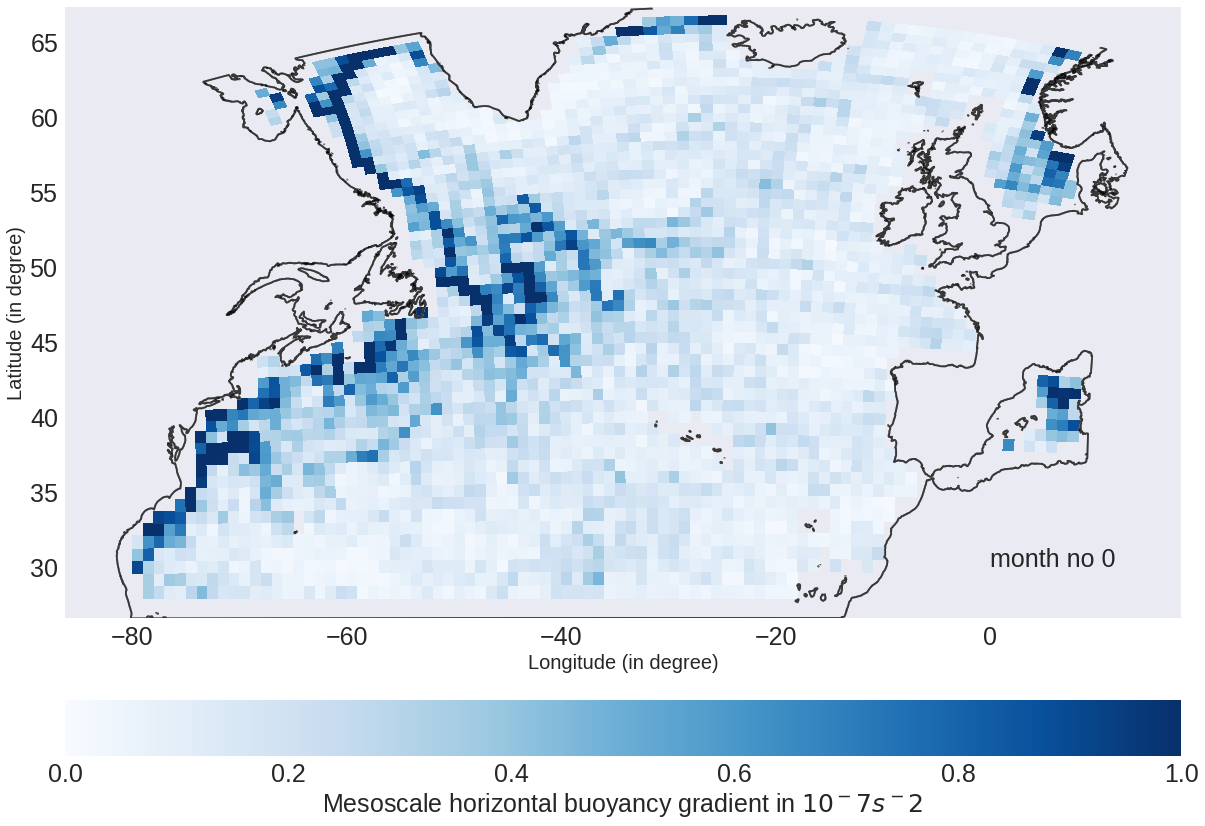

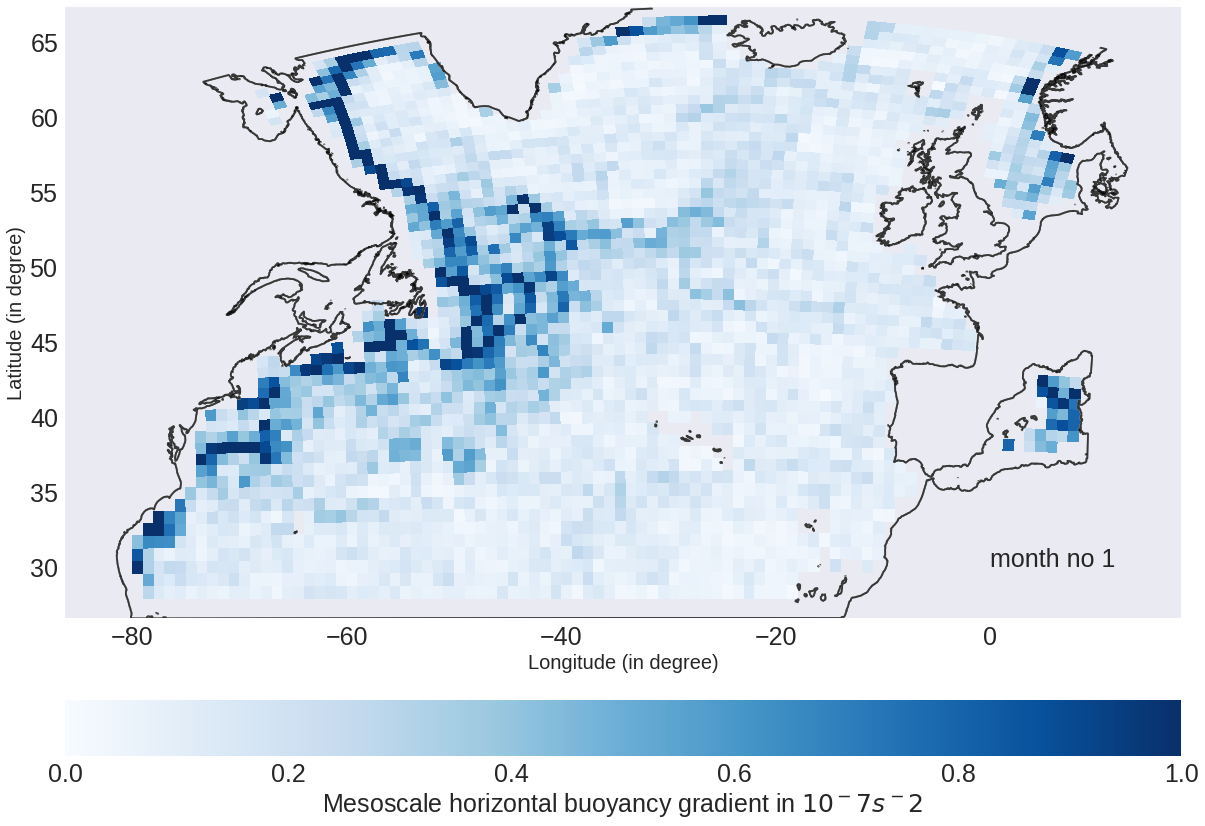

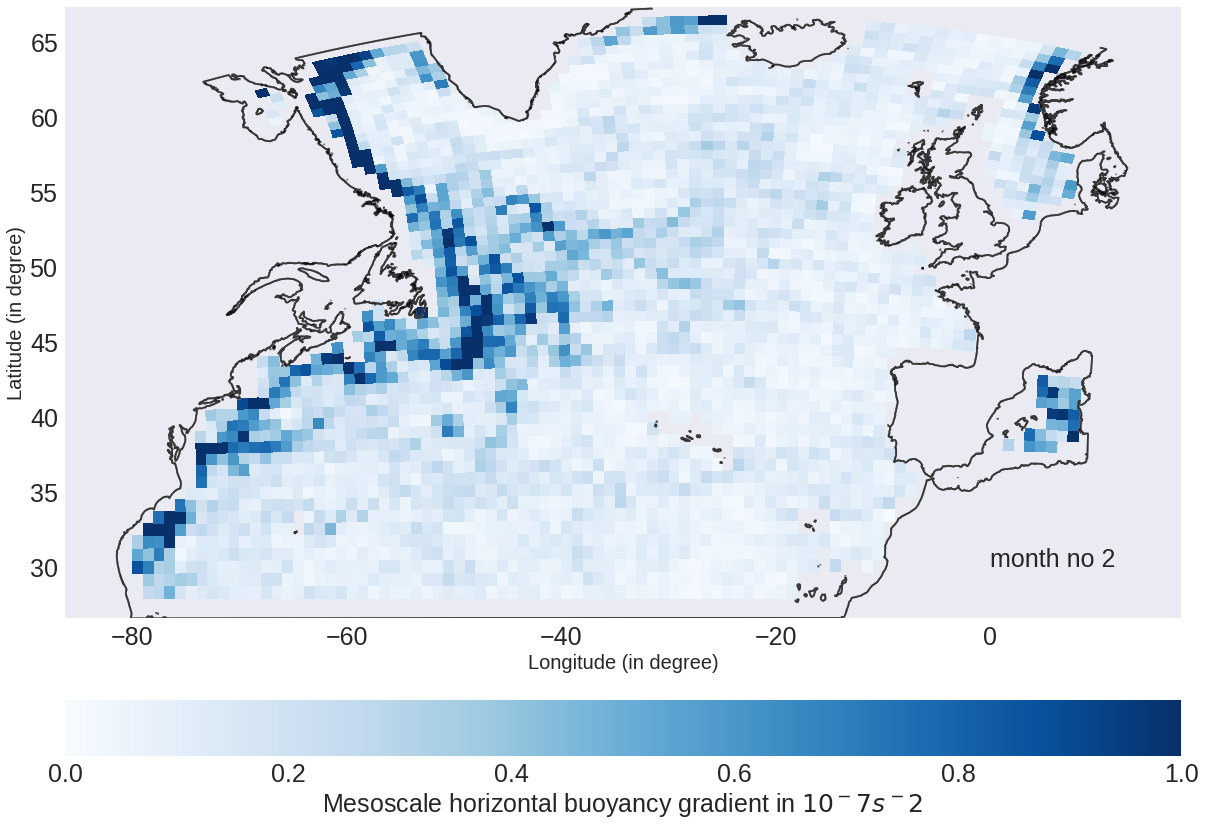

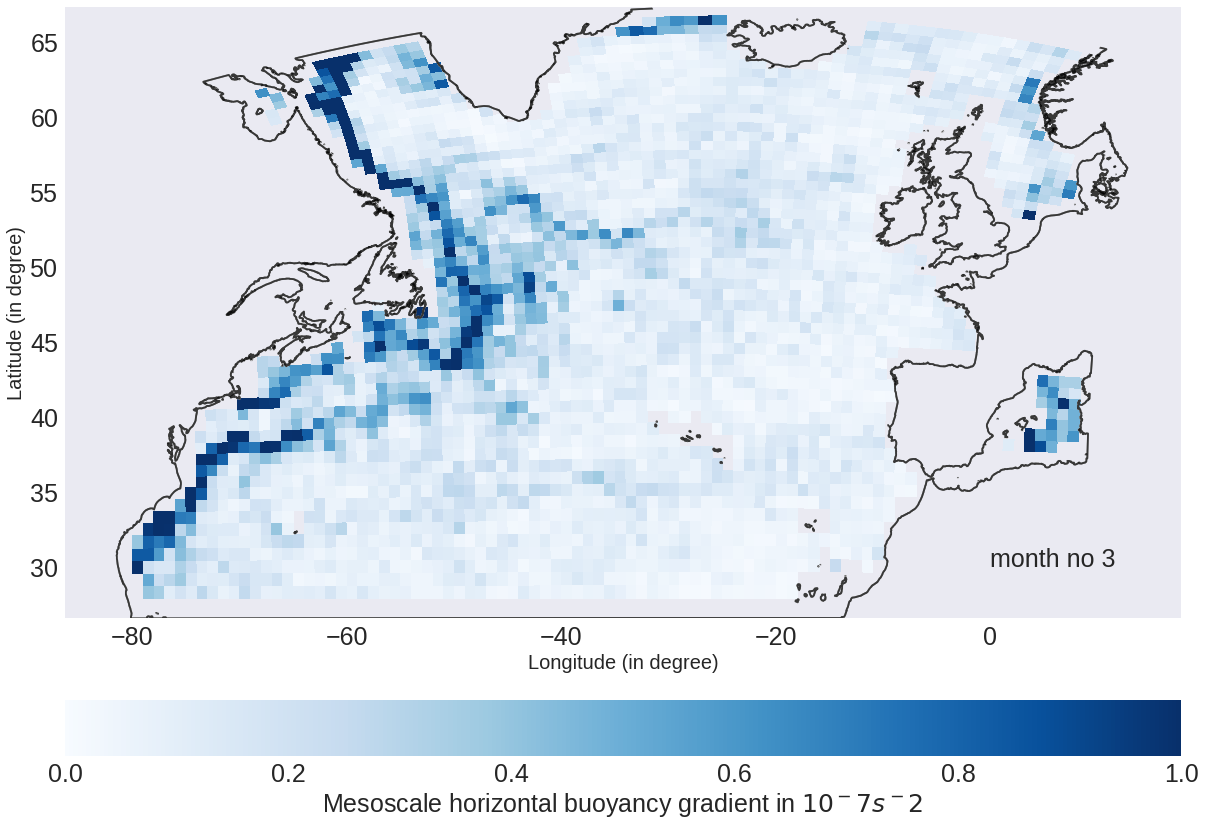

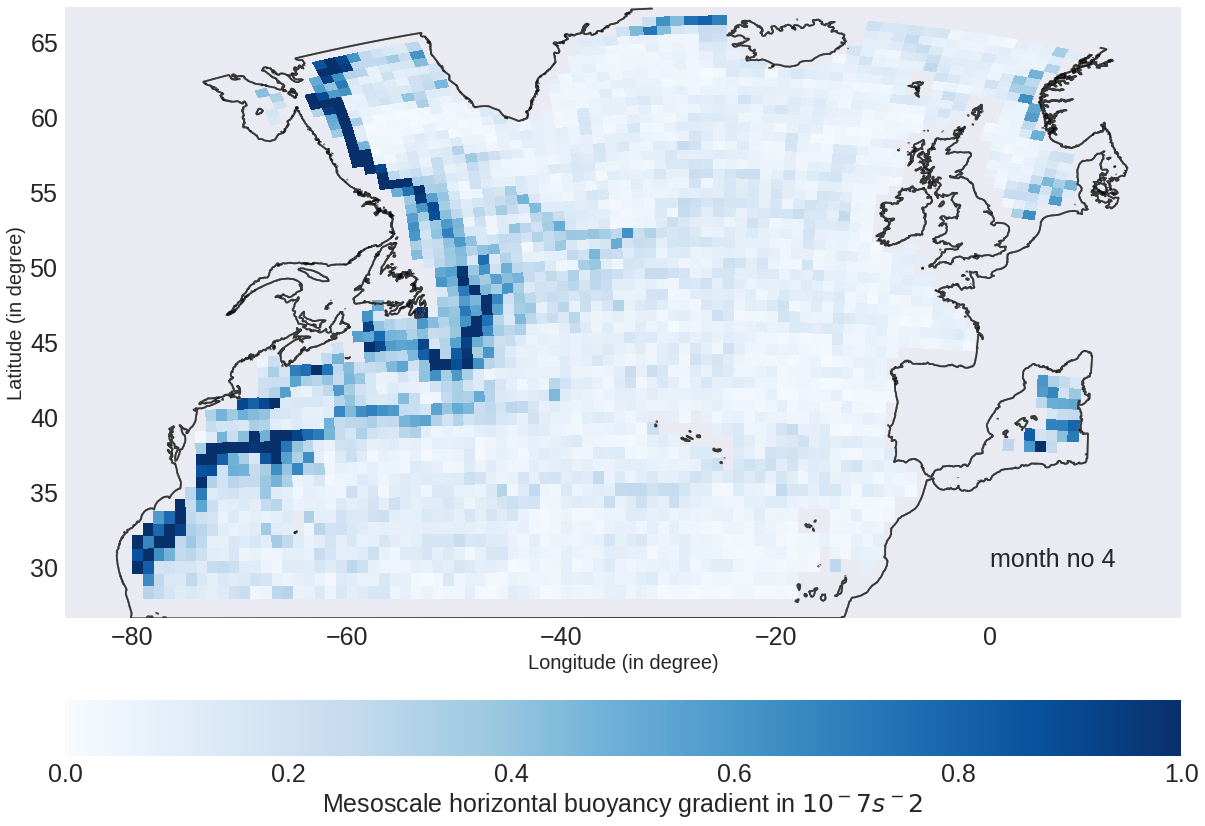

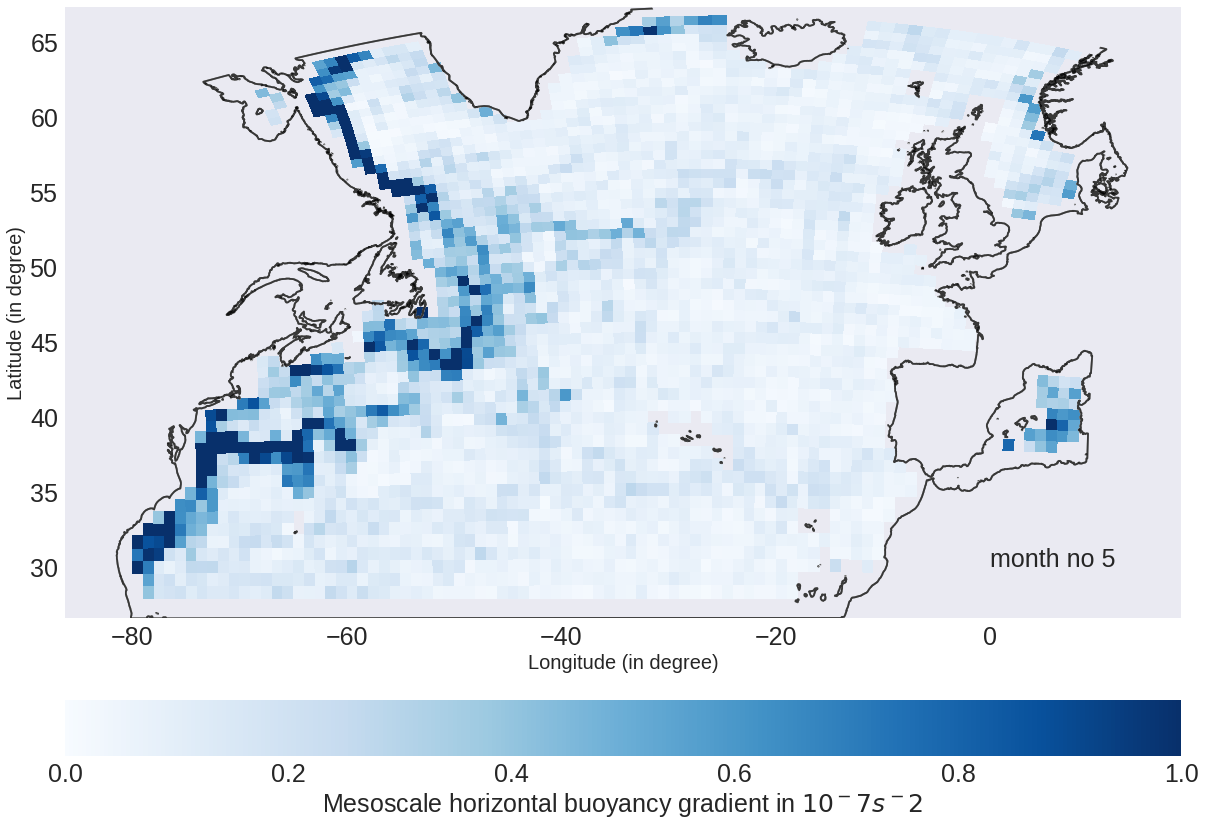

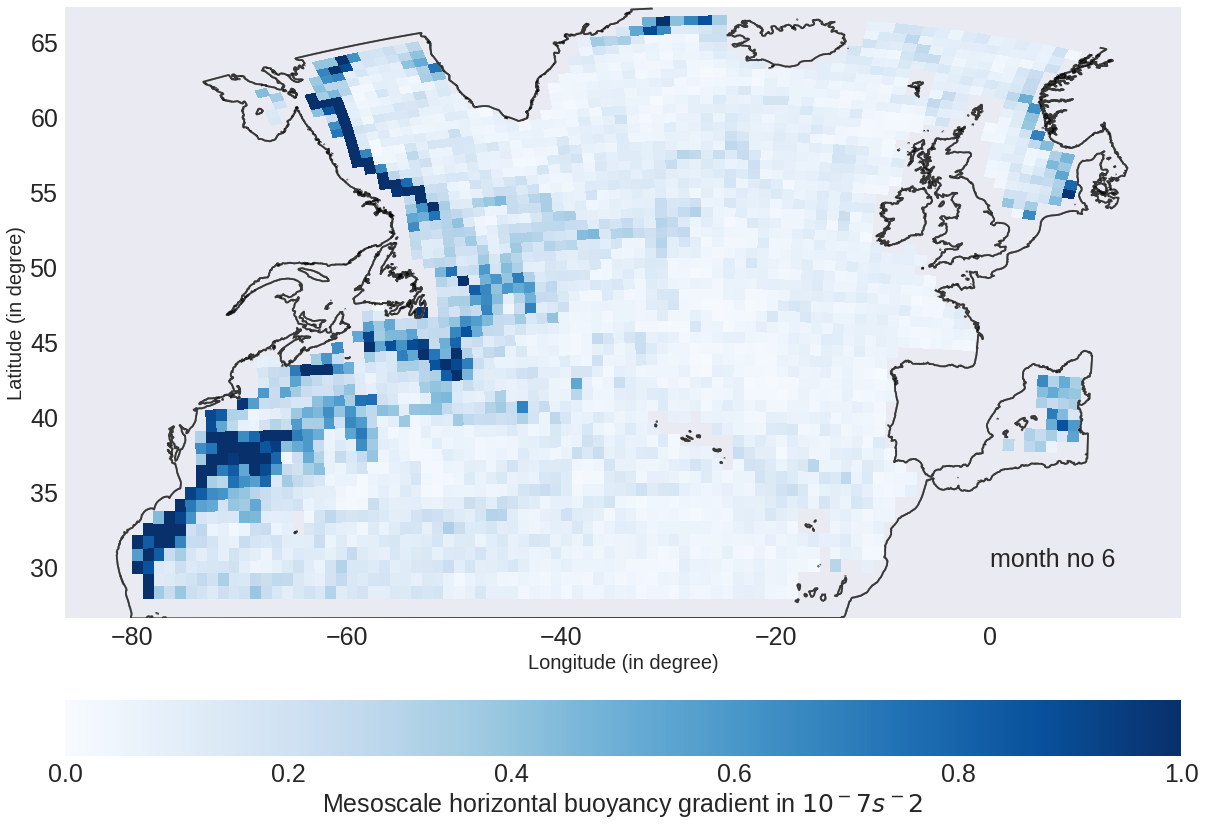

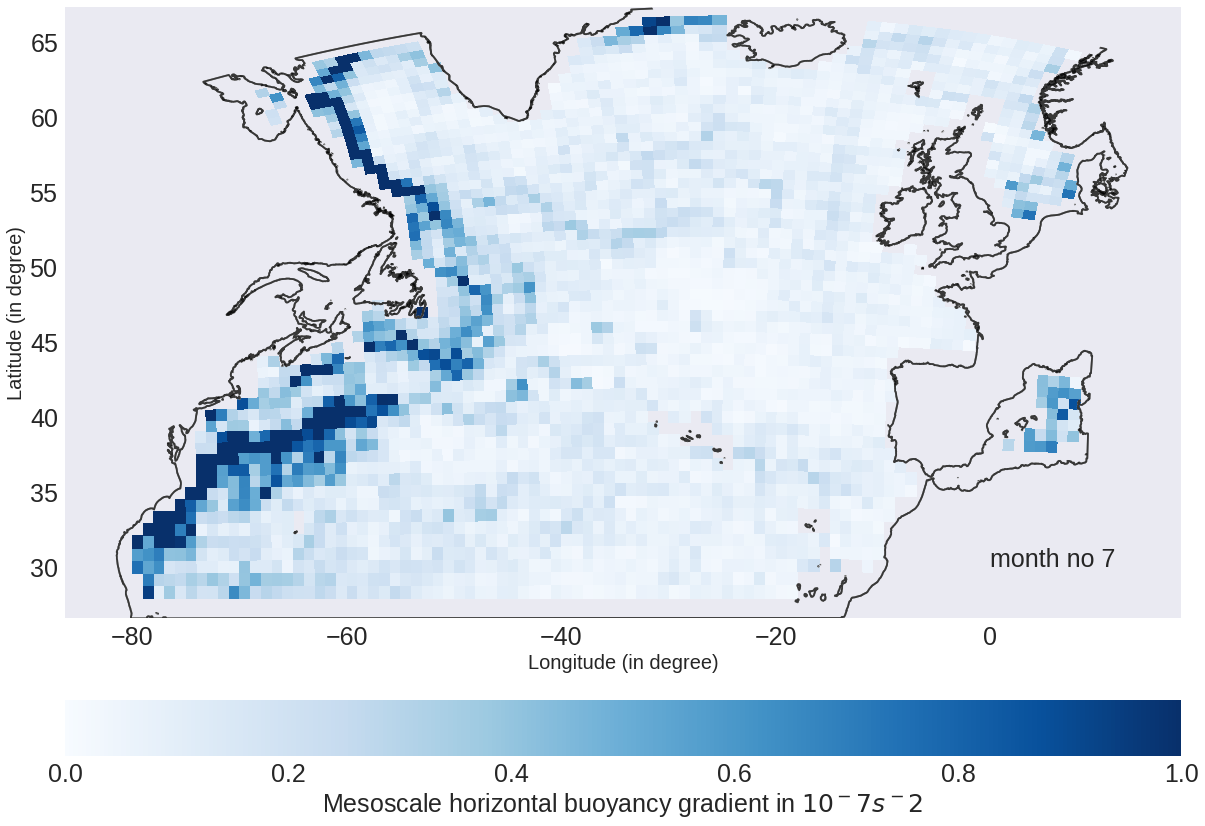

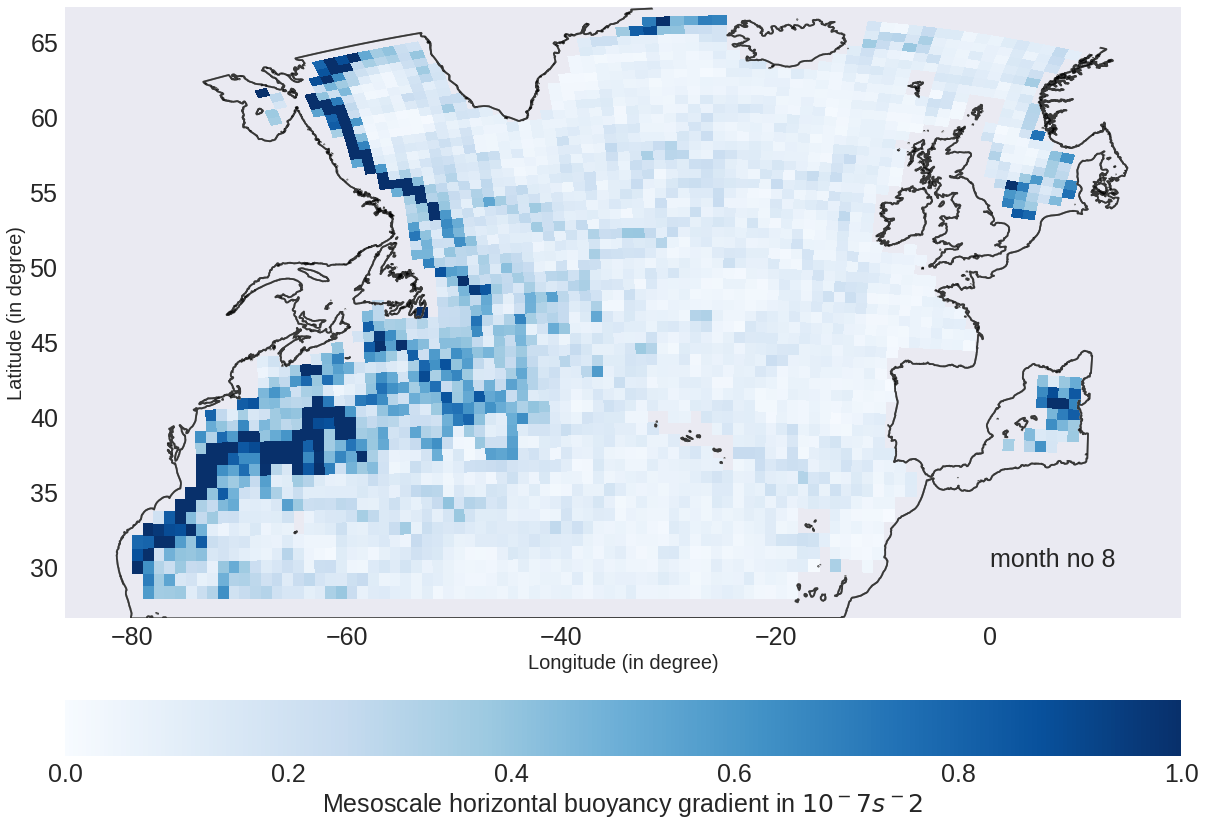

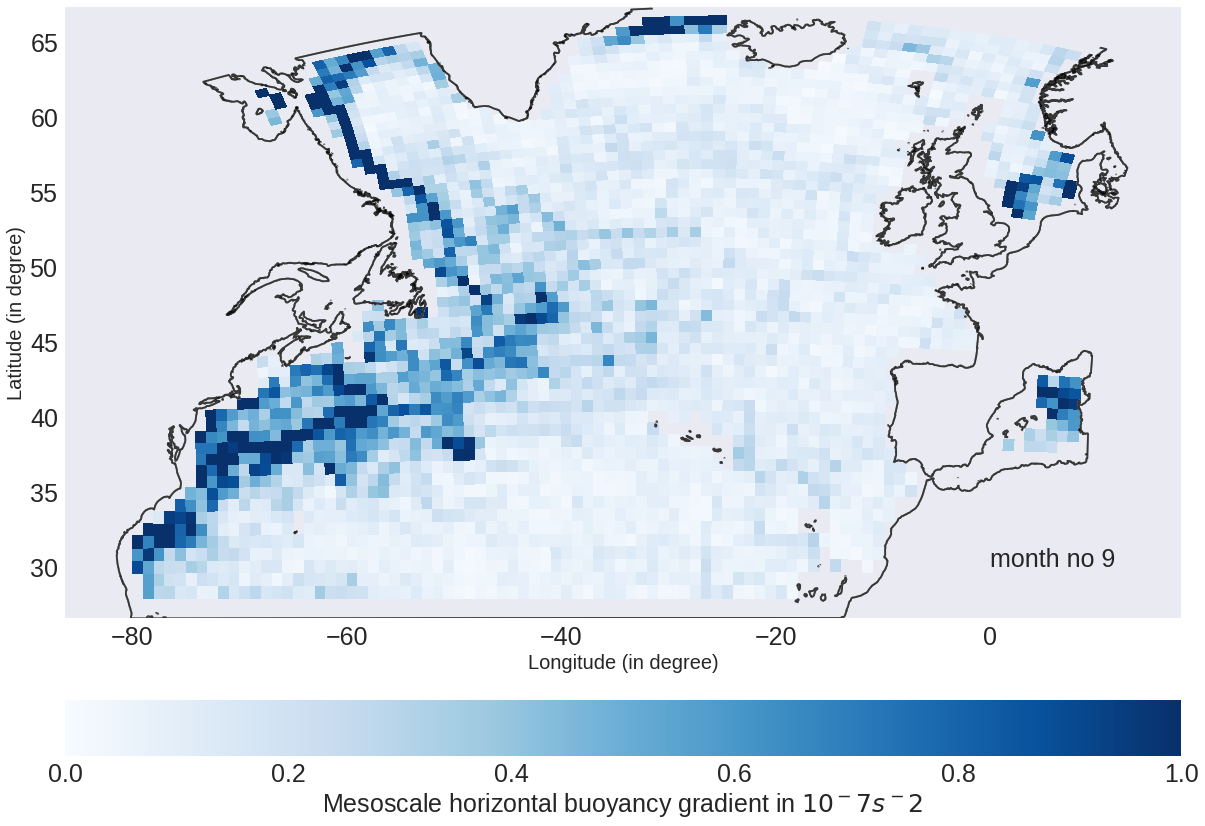

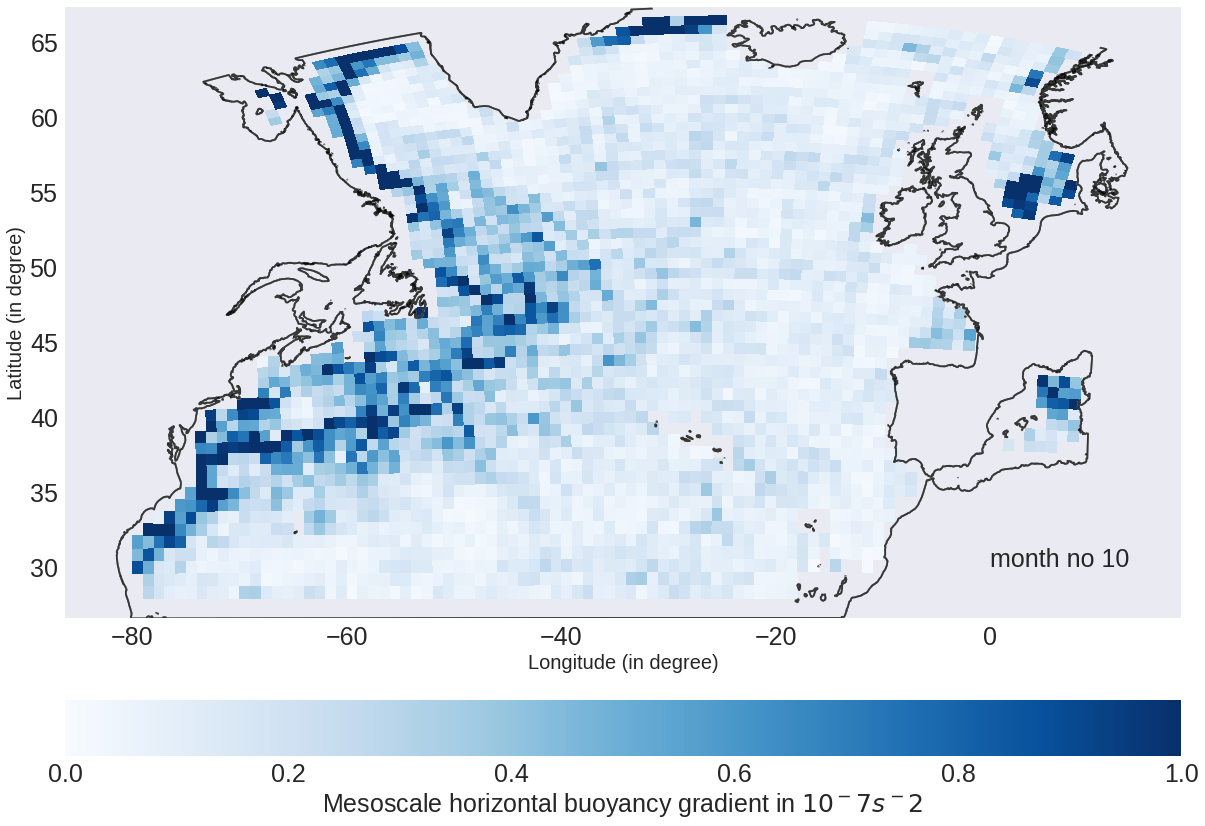

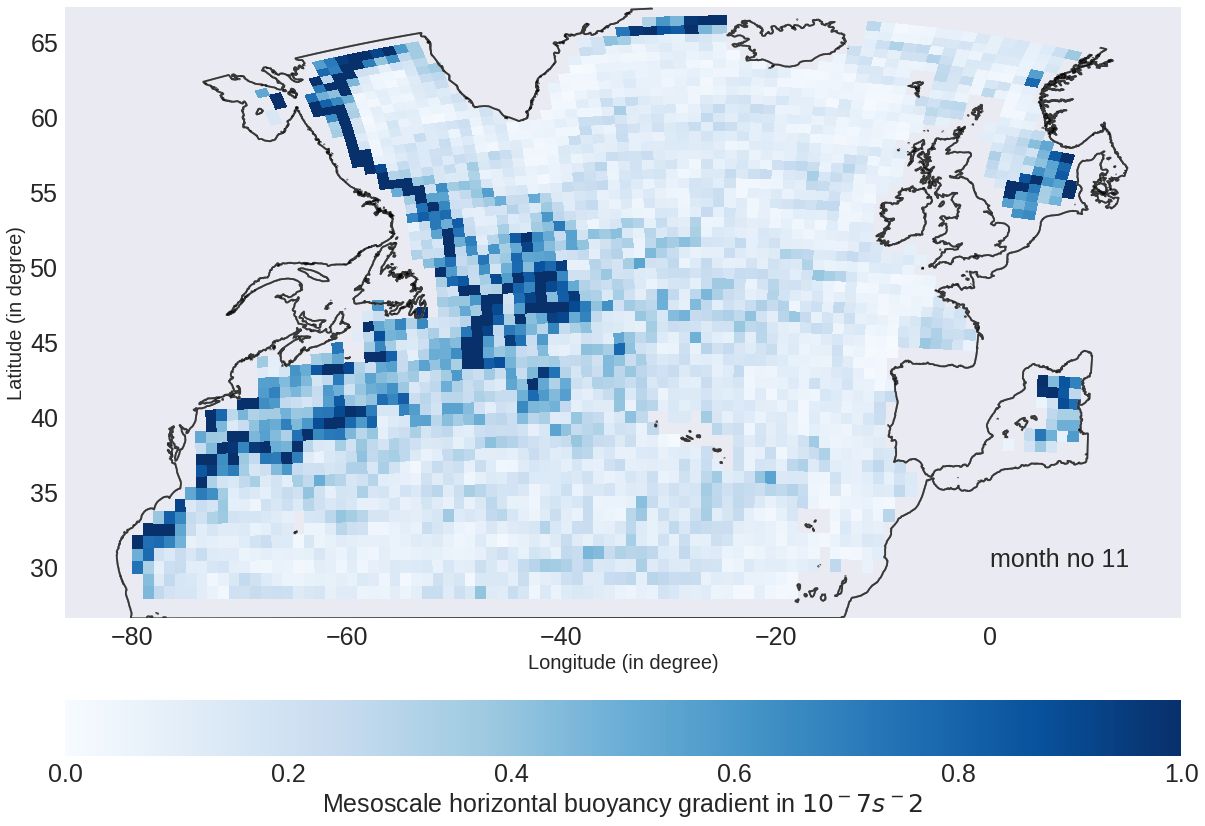

In [19]:

for k in np.arange(12):
    fig = plt.figure(figsize=(20, 15))

    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    truc=np.array(hgradbf[0])
    truc[truc==0.]=np.nan
    cont=np.isnan(truc)

    pcolor = ax.pcolormesh(lon[0,:,:],lat[0,:,:],1e7*ma.masked_invalid(np.squeeze(hgradb[k,:,:])),vmin=0,vmax=1,cmap=seq_cmap,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(navlon,navlat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.text(0,30,'month no '+str(k),size=25)
    cbar.set_label('Mesoscale horizontal buoyancy gradient in $10^-7 s^-2$',fontsize=25)
